**Data layout (TIFF supported):**
```
./Data/
  Train/
    Normal/      *.tif, *.tiff, *.png, *.jpg
    Abnormal/    *.tif, *.tiff, *.png, *.jpg
  Validation/
    Normal/
    Abnormal/
  Test/
    Normal/      (used for pretrained-weight evaluation)
    Abnormal/
```
Pretrained weights are auto-downloaded from Google Drive into `./checkpoints/<ckpt_name>` right before evaluation.

> **Colab/GitHub-ready:** This notebook uses relative paths (`./data`, `./checkpoints`) so it runs smoothly when opened from GitHub in Colab.  
> **Training:** runs for **5 epochs** and saves to `./checkpoints/best_train.pth`.  
> **Evaluation:** uses your pretrained file `./checkpoints/epoch=75-val_loss=0.69-val_acc=0.77.ckpt`.

# 🧪 Sperm Classification (Normal vs Abnormal) — ResNet (Colab Notebook)

**Goal:** quick, accurate *trial* training run (5 epochs) using **ResNet-34**. This notebook keeps key hyperparameters consistent with your setup: **image size 800×800** and normalization `mean=0.2636`, `std=0.1562`. It also provides a simple evaluation section to load **your pretrained weights** and run on test images.

> Tip: If you store data/weights in Google Drive, use the Drive mount cell below.

In [31]:
# --- Clone the repo only if needed; enter the correct folder ---
import os, subprocess
from pathlib import Path

REPO_URL = "https://github.com/KikuchiJun1/MicroTas-2025-Workshop-11.git"
TARGET_DIR = Path("classification_repo")

def run(cmd, cwd=None):
    print("$", " ".join(cmd))
    r = subprocess.run(cmd, cwd=cwd, text=True,
                       stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    print(r.stdout)
    r.check_returncode()
    return r

if not (TARGET_DIR / ".git").exists():
    if TARGET_DIR.exists() and any(TARGET_DIR.iterdir()):
        raise RuntimeError(f"Destination '{TARGET_DIR}' exists and is not empty.")
    print("Cloning repository...")
    run(["git", "clone", "--depth", "1", REPO_URL, str(TARGET_DIR)])
else:
    print("✓ Repo already cloned.")
    run(["git", "fetch", "--all", "--prune"], cwd=TARGET_DIR)
    run(["git", "pull", "--ff-only"], cwd=TARGET_DIR)

# Enter the 'classification' folder where Data/ lives
os.chdir(TARGET_DIR)
if Path("classification").exists():
    os.chdir("classification")
print("CWD:", os.getcwd())
print("Here:", os.listdir(".")[:10])


Cloning repository...
$ git clone --depth 1 https://github.com/KikuchiJun1/MicroTas-2025-Workshop-11.git classification_repo
Cloning into 'classification_repo'...
Updating files:  94% (3975/4212)
Updating files:  95% (4002/4212)
Updating files:  96% (4044/4212)
Updating files:  97% (4086/4212)
Updating files:  98% (4128/4212)
Updating files:  99% (4170/4212)
Updating files: 100% (4212/4212)
Updating files: 100% (4212/4212), done.

CWD: /content/classification_repo/classification/classification_repo/classification
Here: ['Classification.ipynb', 'Classification_V3.ipynb', 'Data']


In [32]:
# --- Locate Data folder robustly & define CFG ---
import os
from dataclasses import dataclass
from pathlib import Path

# Find Data/
CANDIDATES = [
    Path("./Data"),
    Path("./classification/Data"),
    Path("./classification_repo/classification/Data"),
    Path("/content/classification_repo/classification/Data"),
]
DATA_DIR = next((p.resolve() for p in CANDIDATES if p.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("Couldn't find the Data folder. Checked:\n" + "\n".join(map(str, CANDIDATES)))

print("Using DATA_DIR:", DATA_DIR)

@dataclass
class CFG:
    # Paths
    data_dir: str = str(DATA_DIR)
    save_dir: str = "./checkpoints"
    train_ckpt_name: str = "resnet18_best.pth"   # our training save name
    # Training (keep as you had unless you change)
    epochs: int = 5
    batch_size: int = 8
    num_workers: int = 0        # set >0 if your runtime is stable
    lr: float = 1e-4
    weight_decay: float = 0.0
    seed: int = 42
    # Image/Transforms (keep your workshop stats)
    img_size: int = 800
    mean: float = 0.2636
    std: float = 0.1562

cfg = CFG()
os.makedirs(cfg.save_dir, exist_ok=True)
print(cfg)


Using DATA_DIR: /content/classification_repo/classification/classification_repo/classification/Data
CFG(data_dir='/content/classification_repo/classification/classification_repo/classification/Data', save_dir='./checkpoints', train_ckpt_name='resnet18_best.pth', epochs=5, batch_size=8, num_workers=0, lr=0.0001, weight_decay=0.0, seed=42, img_size=800, mean=0.2636, std=0.1562)


In [ ]:
# --- Datasets, loaders, and (optional) training of ResNet-18 ---
import random, numpy as np, torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim

# Repro
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True   # fixed size → speed
set_seed(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms (grayscale -> 3ch; your stats & size)
IM_SIZE = cfg.img_size
MEAN = [cfg.mean]*3
STD  = [cfg.std]*3

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Folders
import os
train_dir = os.path.join(cfg.data_dir, "Train")
val_dir   = os.path.join(cfg.data_dir, "Validation")
test_dir  = os.path.join(cfg.data_dir, "Test")

# Datasets
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=val_tfms)
class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Loaders
pin = torch.cuda.is_available()
loader_kwargs = dict(batch_size=cfg.batch_size, pin_memory=pin, num_workers=cfg.num_workers)
train_loader = DataLoader(train_ds, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_kwargs)

# --- Model: ALWAYS ResNet-18 ---
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Replace head
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

# Optional: quick training loop (run if you want to fine-tune; else skip this cell)
def run_epoch(model, loader, train=True):
    model.train(mode=train)
    total, correct, loss_sum = 0, 0, 0.0
    if train:
        ctx = torch.enable_grad()
    else:
        ctx = torch.inference_mode()
    with ctx:
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                loss.backward(); optimizer.step()
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum / max(1,total), correct / max(1,total)

best_val = 0.0
for ep in range(1, cfg.epochs+1):
    tr_loss, _ = run_epoch(resnet, train_loader, True)
    va_loss, va_acc = run_epoch(resnet, val_loader, False)
    if va_acc > best_val:
        best_val = va_acc
        torch.save({"model_state": resnet.state_dict(),
                    "class_names": class_names}, os.path.join(cfg.save_dir, cfg.train_ckpt_name))
    print(f"Epoch {ep:02d}/{cfg.epochs} | train_loss {tr_loss:.4f} | val_loss {va_loss:.4f} | val_acc {va_acc:.4f}")

print("Best val_acc:", best_val)


Device: cpu
Classes: ['Abnormal', 'Normal']
Epoch 01/5 | train_loss 0.7080 | val_loss 1.3556 | val_acc 0.5000
Epoch 02/5 | train_loss 0.7228 | val_loss 1.1421 | val_acc 0.0000


In [ ]:
# --- Evaluate ResNet-18 on Data/Test with weights saved during training (resnet18_best.pth) ---
import os, torch
from pathlib import Path
import numpy as np
from torch import nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# Preconditions
assert 'cfg' in globals(), "cfg not found. Run earlier chunks to define CFG."
TRAIN_WEIGHTS_PATH = os.path.join(cfg.save_dir, cfg.train_ckpt_name)
if not (os.path.exists(TRAIN_WEIGHTS_PATH) and os.path.getsize(TRAIN_WEIGHTS_PATH) > 0):
    raise FileNotFoundError(
        f"Trained weights not found at {TRAIN_WEIGHTS_PATH}.\n"
        f"Run the training in Chunk 3 or set cfg.train_ckpt_name/cfg.save_dir accordingly."
    )
print("Using trained weights:", TRAIN_WEIGHTS_PATH)

# Locate Test
DATA_DIR = Path(cfg.data_dir)
TEST_DIR = DATA_DIR / "Validation"
assert TEST_DIR.is_dir(), f"Missing Test folder at: {TEST_DIR}"
print("Test dir:", TEST_DIR)

# Transforms (same stats/size as training)
IM_SIZE = cfg.img_size
MEAN = [cfg.mean]*3
STD  = [cfg.std]*3
val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Dataset/loader
test_ds = datasets.ImageFolder(str(TEST_DIR), transform=val_tfms)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

pin = torch.cuda.is_available()
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=pin)
test_paths = [p for p, _ in test_ds.samples]

# Model: ALWAYS ResNet-18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_ckpt_any(path):
    """Safe loader for PyTorch 2.6+ (handles weights_only default)."""
    try:
        return torch.load(path, map_location="cpu")  # tries weights_only=True first
    except Exception:
        try:
            from torch.serialization import add_safe_globals
            import torch.nn.functional as F
            add_safe_globals([F.cross_entropy])
            return torch.load(path, map_location="cpu")
        except Exception:
            # Last resort (only if you trust the file)
            return torch.load(path, map_location="cpu", weights_only=False)

ckpt = load_ckpt_any(TRAIN_WEIGHTS_PATH)

model_eval = models.resnet18(weights=None)
model_eval.fc = nn.Linear(model_eval.fc.in_features, num_classes)

state_dict = ckpt.get("model_state", ckpt.get("state_dict", ckpt))
missing, unexpected = model_eval.load_state_dict(state_dict, strict=False)
if missing or unexpected:
    print("Note: non-strict load → missing:", missing, "| unexpected:", unexpected)

model_eval = model_eval.to(device).eval()

# Prefer saved class names if present
class_names_inf = ckpt.get("class_names", class_names)

# Inference
all_logits, all_labels = [], []
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = model_eval(x)
        all_logits.append(logits.cpu())
        all_labels.append(y)

all_logits = torch.cat(all_logits, 0)
all_labels = torch.cat(all_labels, 0).numpy()
probs = torch.softmax(all_logits, dim=1).numpy()
preds = probs.argmax(1)

# Metrics
acc = (preds == all_labels).mean()
print(f"\nTest Accuracy (trained weights): {acc:.4f}\n")
print("Classification report (trained weights):")
print(classification_report(all_labels, preds, target_names=class_names_inf, digits=4))

# Confusion matrix (visual)
cm = confusion_matrix(all_labels, preds)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Test) — Trained Weights')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(len(class_names_inf)), class_names_inf, rotation=45, ha='right')
    plt.yticks(range(len(class_names_inf)), class_names_inf)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i,j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("(Skipping CM plot)", e)

# Per-image probabilities → CSV (trained weights)
import pandas as pd
rows = []
for i, path in enumerate(test_paths):
    row = {"path": path,
           "true_label": class_names_inf[all_labels[i]],
           "pred_label": class_names_inf[preds[i]]}
    for ci, cname in enumerate(class_names_inf):
        row[f"prob_{cname}"] = float(probs[i, ci])
    rows.append(row)
df = pd.DataFrame(rows)
print("\nPer-image probabilities (head) — trained weights:")
print(df.head(10))
df.to_csv("test_predictions_trained.csv", index=False)
print("\nSaved per-image predictions to: test_predictions_trained.csv")


In [28]:
# --- Download pretrained ResNet-18 weights for evaluation (fixed URL) ---
import os, sys, subprocess, shlex
from pathlib import Path

WEIGHTS_ID   = "1pF4UOUmU9VU-mJU9MW6YWAINbCdKedMX"  # << YOUR PROVIDED LINK
WEIGHTS_URL  = f"https://drive.google.com/uc?id={WEIGHTS_ID}"
WEIGHTS_PATH = os.path.join("checkpoints", "epoch=85-val_loss=0.97-val_acc=0.76.ckpt")

def _have(p):
    return os.path.exists(p) and os.path.getsize(p) > 0

os.makedirs(os.path.dirname(WEIGHTS_PATH), exist_ok=True)

if not _have(WEIGHTS_PATH):
    print("Attempting to download pretrained weights...")
    ok = False
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-U", "gdown>=5.2.0"], check=True)
        subprocess.run(["gdown", WEIGHTS_URL, "-O", WEIGHTS_PATH, "--fuzzy"], check=True)
        ok = _have(WEIGHTS_PATH)
    except subprocess.CalledProcessError as e:
        print("gdown failed:", e)

    if not ok:
        print("Trying wget fallback...")
        cookies = "/tmp/gdcookies.txt"
        try:
            cmd1 = f'wget --quiet --save-cookies {shlex.quote(cookies)} --keep-session-cookies --no-check-certificate "{WEIGHTS_URL}" -O-'
            cmd2 = r"sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' | head -n 1"
            token = subprocess.check_output(f"{cmd1} | {cmd2}", shell=True, text=True).strip()
            if token:
                dl = f"https://drive.google.com/uc?export=download&confirm={token}&id={WEIGHTS_ID}"
                subprocess.run(f'wget --load-cookies {shlex.quote(cookies)} "{dl}" -O {shlex.quote(WEIGHTS_PATH)} -q --no-check-certificate', shell=True)
        finally:
            try: os.remove(cookies)
            except OSError: pass
        ok = _have(WEIGHTS_PATH)

    if ok:
        print(f"✓ Downloaded to {WEIGHTS_PATH}")
    else:
        raise RuntimeError("Could not download pretrained weights. Check Drive sharing or host elsewhere.")
else:
    print(f"✓ Weights already exist at {WEIGHTS_PATH}")


✓ Weights already exist at checkpoints/epoch=85-val_loss=0.97-val_acc=0.76.ckpt


Test dir: /content/classification_repo/classification/Data/Validation
Classes: ['Abnormal', 'Normal']
Note: non-strict load → missing: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.downsample.0.weig

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


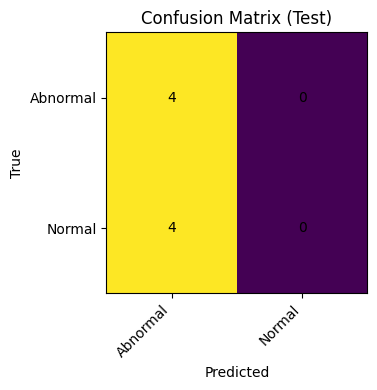


Per-image probabilities (head):
                                                path true_label pred_label  \
0  /content/classification_repo/classification/Da...   Abnormal   Abnormal   
1  /content/classification_repo/classification/Da...   Abnormal   Abnormal   
2  /content/classification_repo/classification/Da...   Abnormal   Abnormal   
3  /content/classification_repo/classification/Da...   Abnormal   Abnormal   
4  /content/classification_repo/classification/Da...     Normal   Abnormal   
5  /content/classification_repo/classification/Da...     Normal   Abnormal   
6  /content/classification_repo/classification/Da...     Normal   Abnormal   
7  /content/classification_repo/classification/Da...     Normal   Abnormal   

   prob_Abnormal  prob_Normal  
0       0.754535     0.245465  
1       0.752382     0.247618  
2       0.756716     0.243284  
3       0.754375     0.245625  
4       0.998577     0.001423  
5       0.998577     0.001423  
6       0.998577     0.001423  
7       

In [30]:
# --- Evaluate ResNet-18 on Data/Test with the downloaded pretrained weights ---
import torch
from torch import nn
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from pathlib import Path
from torchvision import datasets, transforms

# Reuse config & stats
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Locate Test
DATA_DIR = Path(cfg.data_dir)
TEST_DIR = DATA_DIR / "Validation"
assert TEST_DIR.is_dir(), f"Missing Test folder at: {TEST_DIR}"
print("Test dir:", TEST_DIR)

# Transforms (keep same as training stats)
IM_SIZE = cfg.img_size
MEAN = [cfg.mean]*3
STD  = [cfg.std]*3
val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Dataset/loader
test_ds = datasets.ImageFolder(str(TEST_DIR), transform=val_tfms)
class_names = test_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_paths = [p for p, _ in test_ds.samples]

# --- Always build ResNet-18 and load weights safely (PyTorch 2.6+) ---
def load_ckpt_any(path):
    try:
        return torch.load(path, map_location="cpu")  # weights_only=True default in PT 2.6
    except Exception:
        try:
            from torch.serialization import add_safe_globals
            import torch.nn.functional as F
            add_safe_globals([F.cross_entropy])
            return torch.load(path, map_location="cpu")
        except Exception:
            # Last resort if you trust the checkpoint
            return torch.load(path, map_location="cpu", weights_only=False)

ckpt = load_ckpt_any(WEIGHTS_PATH)

resnet_eval = models.resnet18(weights=None)  # head will be replaced; we load your trained weights
resnet_eval.fc = nn.Linear(resnet_eval.fc.in_features, num_classes)
missing, unexpected = resnet_eval.load_state_dict(
    # Accept either full state_dict or under 'model_state'
    ckpt.get("state_dict", ckpt.get("model_state", ckpt)),
    strict=False
)
if missing or unexpected:
    print("Note: non-strict load → missing:", missing, "| unexpected:", unexpected)

resnet_eval = resnet_eval.to(device).eval()

# If class names were saved inside the ckpt, prefer them for labeling
class_names_inf = ckpt.get("class_names", class_names)

# Inference
all_logits, all_labels = [], []
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits = resnet_eval(x)
        all_logits.append(logits.cpu())
        all_labels.append(y)

all_logits = torch.cat(all_logits, 0)
all_labels = torch.cat(all_labels, 0).numpy()
probs = torch.softmax(all_logits, dim=1).numpy()
preds = probs.argmax(1)

# Metrics
acc = (preds == all_labels).mean()
print(f"\nTest Accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(all_labels, preds, target_names=class_names_inf, digits=4))

# Confusion matrix (visual)
cm = confusion_matrix(all_labels, preds)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Test)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(len(class_names_inf)), class_names_inf, rotation=45, ha='right')
    plt.yticks(range(len(class_names_inf)), class_names_inf)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i,j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("(Skipping CM plot)", e)

# Per-image probabilities → CSV
import pandas as pd
rows = []
for i, path in enumerate(test_paths):
    row = {"path": path,
           "true_label": class_names_inf[all_labels[i]],
           "pred_label": class_names_inf[preds[i]]}
    for ci, cname in enumerate(class_names_inf):
        row[f"prob_{cname}"] = float(probs[i, ci])
    rows.append(row)
df = pd.DataFrame(rows)
print("\nPer-image probabilities (head):")
print(df.head(10))
df.to_csv("test_predictions.csv", index=False)
print("\nSaved per-image predictions to: test_predictions.csv")
